In [17]:
%pip install wbdata
from __future__ import annotations
import time
from functools import lru_cache
from typing import Literal
import wbdata
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt


Note: you may need to restart the kernel to use updated packages.


# 1. Population DataFrames [A]

### Helper Functions

In [ ]:
#Helper Functions

Sex = Literal["female", "male", "total"]

AGE_BINS_5Y = [
    "0004","0509","1014","1519","2024","2529","3034","3539",
    "4044","4549","5054","5559","6064","6569","7074","7579","80UP"
]

BIN_TO_RANGE = {
    "0004": (0,4),   "0509": (5,9),   "1014": (10,14), "1519": (15,19),
    "2024": (20,24), "2529": (25,29), "3034": (30,34), "3539": (35,39),
    "4044": (40,44), "4549": (45,49), "5054": (50,54), "5559": (55,59),
    "6064": (60,64), "6569": (65,69), "7074": (70,74), "7579": (75,79),
    "80UP": (80,200),
}

def bins_for_age_range(start_age: int, end_age: int) -> list[str]:
    ''' >>> bins_for_age_range(start_age = 0, end_age = 9)
        return: ['0004', '0509']
        '''
    return [b for b,(lo,hi) in BIN_TO_RANGE.items() if not (hi < start_age or lo > end_age)]

def wb_indicator_5y(age_code: str, sex: str) -> str:
    ''' This helper constructs variable indicator.
    >>> wb_indicator_5y(age_code = '0004', sex = 'female')
    output: "SP.POP.0004.FE"
    '''
    
    sex_code = "FE" if sex == "female" else "MA"
    return f"SP.POP.{age_code}.{sex_code}"

Below is validation helper functions

In [ ]:
def _validate_years(years: tuple[int, int]) -> None:
    if (not isinstance(years, tuple)) or len(years) != 2:
        raise TypeError("years must be a tuple of (start_year, end_year)")
    y0, y1 = years
    if not (isinstance(y0, int) and isinstance(y1, int)):
        raise TypeError("years must contain integers")
    if y0 > y1:
        raise ValueError("years must satisfy start_year <= end_year")
    if y0 < 1960 or y1 > 2024:
        raise ValueError("years must be between 1960 and 2024, inclusive")


def _validate_area(area: str) -> str:
    if not isinstance(area, str):
        raise TypeError("area must be a string")
    area = area.strip()
    if not area:
        raise ValueError("area must be a non-empty string")
    return area


def _validate_sex(sex: str) -> Sex:
    if not isinstance(sex, str):
        raise TypeError("sex must be a string")
    sex = sex.strip().lower()
    if sex not in ("female", "male", "total"):
        raise ValueError("sex must be 'female', 'male', or 'total'")
    return sex  # type: ignore[return-value]


def _validate_age_range(age_range: tuple[int, int]) -> tuple[int, int]:
    if (not isinstance(age_range, tuple)) or len(age_range) != 2:
        raise TypeError("age_range must be a tuple (low, high)")
    low, high = age_range
    if not (isinstance(low, int) and isinstance(high, int)):
        raise TypeError("age_range bounds must be integers")
    if low < 0 or high < 0:
        raise ValueError("age_range bounds must be non-negative")
    if low > high:
        raise ValueError("age_range must satisfy low <= high")

    # Exact 5-year boundary validation:
    # valid ranges are unions of 5-year bins, so:
    #   low must be multiple of 5
    #   high must be 4 mod 5
    if (low % 5) != 0 or (high % 5) != 4:
        raise ValueError(
            "age_range must align to 5-year bins, e.g. (0,4), (0,9), (5,14), (15,19)"
        )

    # Optional: enforce max bound if your bins top out (e.g., 100+)
    # You can skip this if AGE_BINS_5Y already handles it robustly.
    return low, high



### Below is the main population DataFrame function.

In [6]:
@lru_cache(maxsize=128)
def population_df(years: tuple[int, int], area: str, chunk: int = 4) -> pd.DataFrame:
    """
    Example: india_pop_df = population_df(years=(2018, 2020), area="India")
    Returns a DataFrame with male and female counts of each 5-year age range.
    Please enter a year between 1960 and 2024. 
    """
    _validate_years(years)
    area = _validate_area(area)
    if not isinstance(chunk, int) or chunk <= 0:
        raise ValueError("chunk must be a positive integer")

    # Resolve country id (kept inside cached function; caching avoids repeat lookups too)
    countries = wbdata.get_countries(query=f"^{re.escape(area)}$")
    if not countries:
        raise ValueError(f"No country matched area={area!r}")
    country_id = countries[0]["id"]

    def fetch(sub_bins: list[str]) -> pd.DataFrame:
        indicators: dict[str, str] = {}
        for b in sub_bins:
            indicators[wb_indicator_5y(b, "female")] = f"female_{b}"
            indicators[wb_indicator_5y(b, "male")] = f"male_{b}"

        last_err: Exception | None = None
        for k in range(5):
            try:
                # Note: skip_cache=True means "do not use wbdata's cache".
                # Our lru_cache handles caching at the function level.
                return wbdata.get_dataframe(
                    indicators,
                    country=country_id,
                    parse_dates=True,
                    skip_cache=True,
                )
            except Exception as e:
                last_err = e
                time.sleep(0.5 * (2 ** k))
        assert last_err is not None
        raise last_err

    parts: list[pd.DataFrame] = []
    for i in range(0, len(AGE_BINS_5Y), chunk):
        parts.append(fetch(AGE_BINS_5Y[i : i + chunk]))

    df = pd.concat(parts, axis=1)

    # Ensure datetime-like index
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index.astype(str), errors="coerce")

    y0, y1 = years
    df = df[(df.index.year >= y0) & (df.index.year <= y1)]

    # Consistent column order: female bins then male bins
    df = df[[f"female_{b}" for b in AGE_BINS_5Y] + [f"male_{b}" for b in AGE_BINS_5Y]]

    df.index = df.index.year
    return df


## Example usage: India, Pakistan, Bangladesh

In [ ]:
india_pop_df = population_df(
    years=(2018, 2020),
    area="India"
)
india_pop_df

In [ ]:
pakistan_pop_df = population_df(
    years=(2018, 2020),
    area="Pakistan"
)
pakistan_pop_df

In [ ]:
bangladesh_pop_df = population_df(
    years=(2018, 2020),
    area="Bangladesh"
)
bangladesh_pop_df

# 2. Population Statistics [A]

This functio answers the question: In [year] how many [people/males/females] aged [low] to [high] were living in [the world/region/country]?

In [ ]:
def population_stats(
    year: int,
    sex: str,
    age_range: tuple[int, int],
    area: str,
) -> int:
    """
    Returns the population count as an integer.
    For variable sex, please enter 'female, 'male', or 'total'.
    Age range should also follow five the head and tail of 5-year range
    ex. 0-4, 5-9, 5-14, 15-29 

    Example:
    pakistan_pop_stats = population_stats(year= 2000, 
                     sex= 'total', 
                     age_range= (15, 29), 
                     area= 'Pakistan')
    output: 41045700
    """
    if not isinstance(year, int):
        raise TypeError("year must be an int")
    if year < 1960 or year > 2024:
        raise ValueError("year must be between 1960 and 2024")

    sex_v = _validate_sex(sex)
    low, high = _validate_age_range(age_range)
    area = _validate_area(area)

    df = population_df((year, year), area)
    if df.empty:
        raise ValueError(f"No data returned for {area!r} in {year}")

    row = df.iloc[0]
    bins = bins_for_age_range(low, high)

    if sex_v == "female":
        count = sum(row[f"female_{b}"] for b in bins)
    elif sex_v == "male":
        count = sum(row[f"male_{b}"] for b in bins)
    else:  # total
        count = sum(row[f"female_{b}"] + row[f"male_{b}"] for b in bins)

    # Be robust to floats/NaNs coming back from wbdata
    if pd.isna(count):
        raise ValueError("Population count is NaN (missing data for one or more bins)")
    return int(count)


def format_population_stats_sentence(
    year: int,
    sex: str,
    age_range: tuple[int, int],
    area: str,
) -> str:
    """
    This returns the wrapper that produces the sentence: 
    In [year] how many [people/males/females] aged [low] to [high] 
    were living in [the world/region/country]?

    """
    sex_v = _validate_sex(sex)
    low, high = _validate_age_range(age_range)
    area = _validate_area(area)

    count = population_stats(year, sex_v, (low, high), area)

    who = {"female": "females", "male": "males", "total": "people"}[sex_v]
    return f"In {year}, there were {count:,} {who} aged {low} to {high} living in {area}."


In [ ]:
india_pop_stats = format_population_stats_sentence(year= 2000, 
                     sex= 'female', 
                     age_range= (15, 29), 
                     area= 'India')
india_pop_stats

In [ ]:
pakistan_pop_stats = format_population_stats_sentence(year= 2000, 
                     sex= 'total', 
                     age_range= (15, 29), 
                     area= 'Pakistan')
pakistan_pop_stats

# Studying India v.s Bangladesh v.s Pakistan Pre- and Post- Liberation War

## Population Growth Rate
First we want to visualize population growth rate

In [ ]:
def population_growth_rate(years,country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query=f"^{re.escape(country)}$")
        return single_country[0]["id"]

    country_id = country_id(country)
    indicators = {"SP.POP.GROW" : "Population growth (annual %)"}

    country_df = wbdata.get_dataframe(indicators, country = country_id, parse_dates = True)

    start, end = years
    growth_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return growth_adjusted.rename(columns = lambda c: country if c == growth_adjusted.columns[0] else c)
    

rate_BGD = population_growth_rate([1961, 1980], "Bangladesh")
rate_IND = population_growth_rate([1961, 1980], "India")
rate_PAK = population_growth_rate([1961, 1980], "Pakistan")


In [ ]:
pop_growth_rate = rate_BGD.join([rate_IND, rate_PAK])
pop_growth_rate.head()

In [ ]:

plt.plot(pop_growth_rate, label = pop_growth_rate.columns )
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Population growth (annual %)")
plt.legend()

### Population growth rate = Birth rate−Death rate+Net migration

The graph clearly shows a major dip around 1971 for Bangladesh, for almost a 1.5% decrease, where many either died or fled to India, as India was located in between the now Bangladesh and Pakistan. Later we will examine both fertility and mortality rate. 

We also want to examine rural v.s urban population growth to grasp if there was uneven impact of the war to urban and rural population.
Below we visualize the comparison or rural v.s urban population growth.

In [7]:
def pop_growth(years,country, indicator):
    
    def country_id(country):
        single_country = wbdata.get_countries(query=f"^{re.escape(country)}$")
        return single_country[0]["id"]

    country_id = country_id(country)


    country_df = wbdata.get_dataframe(indicator, country = country_id, parse_dates = True)

    start, end = years
    growth_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return growth_adjusted.rename(columns = lambda c: country if c == growth_adjusted.columns[0] else c)
    
rural_BGD = pop_growth([1961, 1980], "Bangladesh", {"SP.RUR.TOTL.ZG": "Rural population growth (annual %)"})
rural_IND = pop_growth([1961, 1980], "India",  {"SP.RUR.TOTL.ZG": "Rural population growth (annual %)"})
rural_PAK = pop_growth([1961, 1980], "Pakistan",  {"SP.RUR.TOTL.ZG": "Rural population growth (annual %)"})

Key '7261572386511554378' not in persistent cache.


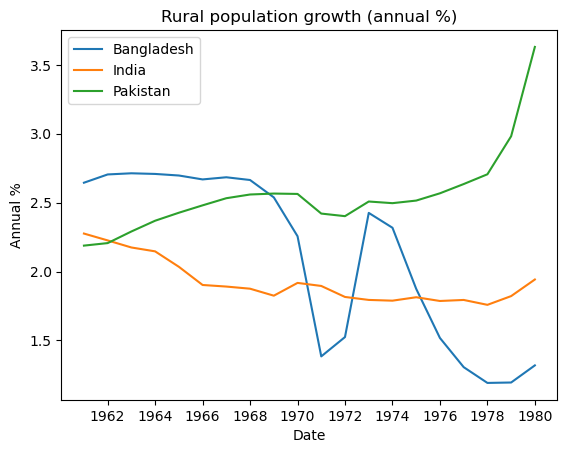

In [8]:
rural_pop_growth = rural_BGD.join([rural_IND, rural_PAK])
plt.plot(rural_pop_growth, label = rural_pop_growth.columns)
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Rural population growth (annual %)")
plt.legend()

In [9]:
urban_BGD = pop_growth([1961, 1980], "Bangladesh", {'SP.URB.GROW':'Urban population growth (annual %)'})
urban_IND = pop_growth([1961, 1980], "India",  {'SP.URB.GROW':'Urban population growth (annual %)'})
urban_PAK = pop_growth([1961, 1980], "Pakistan",  {'SP.URB.GROW':'Urban population growth (annual %)'})

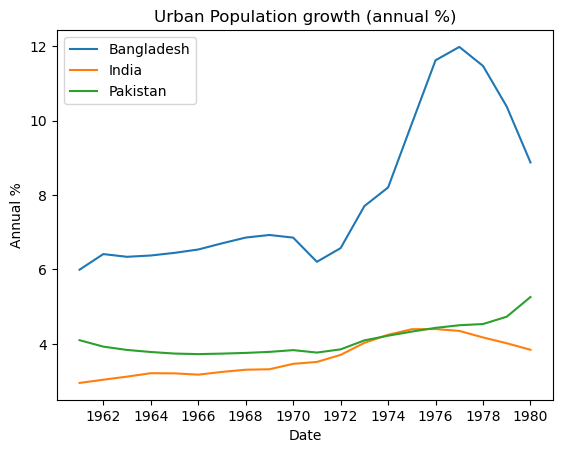

In [10]:
urban_pop = urban_BGD.join([urban_IND, urban_PAK])
plt.plot(urban_pop, label = urban_pop.columns)
plt.ylabel("Annual %")
plt.xlabel("Date")
plt.title("Urban Population growth (annual %)")
plt.legend()

From these two graphs, the population growth curve for Bangladesh and Pakistan looks very similar with about the same magnitude of decrease aroung 1971. However, we discovered a significant distinction between urban population and rural population in Bangladesh. Rural population decreased by 1.5%, but urban population drastically increased by 6%, which indicates fast urbanization. 

Below we examine this change more closely by only focusing on Bangladesh.


Text(0, 0.5, 'Percent (%)')

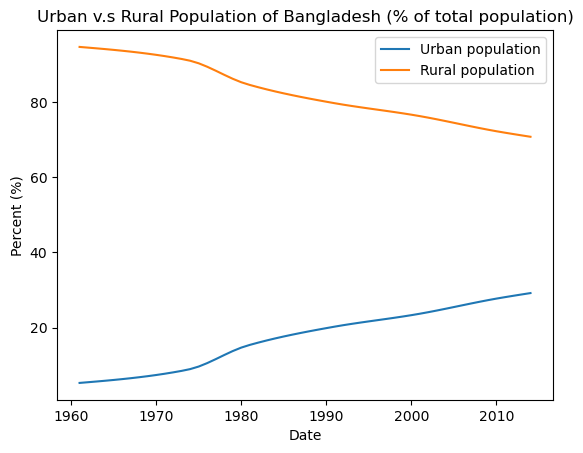

In [12]:
pct_urban_BGD = wbdata.get_dataframe({"SP.URB.TOTL.IN.ZS" : "Urban population (% of total population)"},
                                     country = 'BGD', parse_dates = True)
pct_rural_BGD = wbdata.get_dataframe({'SP.RUR.TOTL.ZS':'Rural population (% of total population)'},
                                     country = 'BGD', parse_dates = True)
compare_pct = pct_urban_BGD.join(pct_rural_BGD)
plt.plot(compare_pct[(compare_pct.index.year >=1961)&(compare_pct.index.year <=2014)], label =['Urban population', 'Rural population'] )
plt.legend()
plt.title('Urban v.s Rural Population of Bangladesh (% of total population)')
plt.xlabel('Date')
plt.ylabel('Percent (%)')



Looking at percentage of total population  we can see the symmetry of decrease in rural population and increase in urban population. Corresponding with the rapid refugee return and urbanization in Bangladesh after war, up until 1977, the election of Ziaur Rahman. During his presidency, he pushed for self-reliance, rural development, and free-market that led to fast economic and industrial growth. 



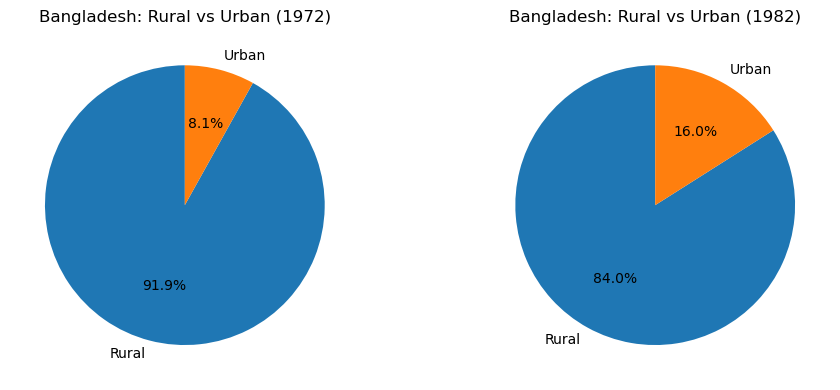

In [13]:


# World Bank indicators
IND = {
    "SP.RUR.TOTL": "Rural",
    "SP.URB.TOTL": "Urban",
}

country = "Bangladesh"
country_id = wbdata.get_countries(query="^Bangladesh$")[0]["id"]

df = wbdata.get_dataframe(
    indicators=IND,
    country=country_id,
    parse_dates=True,
    skip_cache=True
)

# Convert index to year int
df.index = df.index.year

# Grab the two years
years = [1972, 1982]
sub = df.loc[years, ["Rural", "Urban"]].copy()

# (Optional) ensure numeric
sub["Rural"] = pd.to_numeric(sub["Rural"], errors="coerce")
sub["Urban"] = pd.to_numeric(sub["Urban"], errors="coerce")

# Plot: 2 pies side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, y in zip(axes, years):
    vals = sub.loc[y].values
    labels = sub.columns.tolist()
    ax.pie(vals, labels=labels, autopct="%.1f%%", startangle=90)
    ax.set_title(f"{country}: Rural vs Urban ({y})")

plt.tight_layout()
plt.show()


Before 1971, rural population comprises the vast majority of total population. After a decade since the Liberation, along with the new election of President Rahman, the urban population nearly doubled in absolute size over this decade, indicating a significant shift in population dynamics. This growth reflected accelerated urbanization, recovery, and the establishment of Bangladesh. 

# Fertility Rate Comparison

In [15]:
#Fertility rates graphed
tot_fertility_rate = {"SP.DYN.TFRT.IN" : "Fertility rate, total (births per woman)"}

def fertility(years, country):
    
    def country_id(country):
        single_country = wbdata.get_countries(query = country)
        return single_country[0]["id"]

    country_id = country_id(country)
    df = {}
        
    country_df = wbdata.get_dataframe(tot_fertility_rate, country = country_id, parse_dates = True)

    start, end = years
    fertility_adjusted = country_df[(country_df.index.year >= start) & (country_df.index.year <= end)]

    return fertility_adjusted.rename(columns = lambda c: country if c == fertility_adjusted.columns[0] else c)
    
fert_bgd = fertility([1961, 1980], "Bangladesh")
fert_ind = fertility([1961, 1980], "India")
fert_pak = fertility([1961, 1980], "^Pakistan")

Text(0.5, 1.0, 'BGD, IND, PAK Fertility Rate')

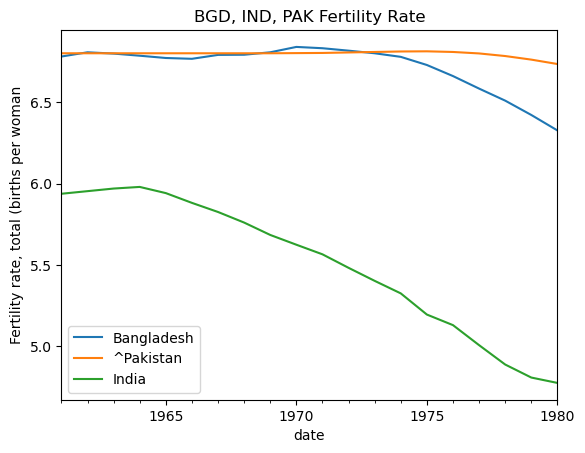

In [16]:
fertility_bangladesh = fert_bgd.copy()
all_fertility = fertility_bangladesh.join(fert_pak).join(fert_ind)

all_fertility.plot()
plt.ylabel('Fertility rate, total (births per woman')
plt.title("BGD, IND, PAK Fertility Rate")

In Bangladesh, a decline in birth rates occurred in the years following the Liberation War.  Since the War lasted less than a year, birth rates saw no significant change during this time. Pakistan's birth rate was steady throughout this time frame.
India’s fertility rate had began declining in 1964.  Starting around 1974, Bangladesh and India saw parallel declinding fertility rates.


# Infant Mortality 